<a href="https://colab.research.google.com/github/jalalsowat/tutorial_YOLO-NAS/blob/main/YOLO_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jalalsowat/tutorial_YOLO-NAS.git

Cloning into 'tutorial_YOLO-NAS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 1.72 MiB | 40.09 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## USE YOLO_NAS

In [2]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [3]:
from super_gradients.training import models
yolo_nas_s = models.get("yolo_nas_s",pretrained_weights='coco')

[2024-03-23 10:39:24] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-23 10:39:27] INFO - utils.py - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-03-23 10:39:27] INFO - utils.py - NumExpr defaulting to 8 threads.
[2024-03-23 10:39:29] WARNING - __init__.py - Failed to import pytorch_quantization
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2024-03-23 10:39:33] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-23 10:39:33] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-23 10:39:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-03-23 10:39:33] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-03-23 10:39:33] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-03-23 10:

In [4]:
!pip install torchinfo

In [5]:
from torchinfo import summary
summary(model=yolo_nas_s,
        input_size=(16,3,640,640),
        col_names =["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_S (YoloNAS_S)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

[2024-03-23 10:39:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


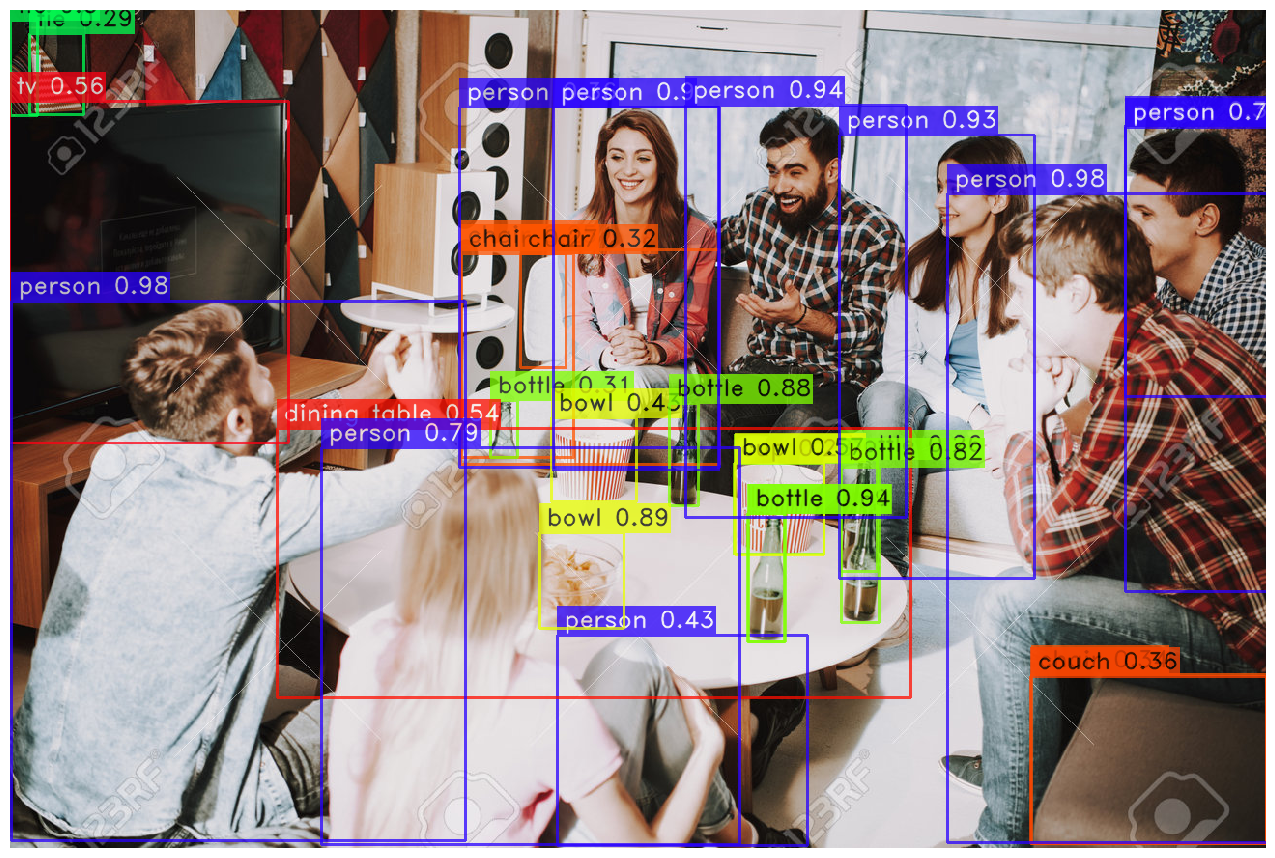

In [6]:
url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
yolo_nas_s.predict(url,conf=0.25).show()

[2024-03-23 10:40:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


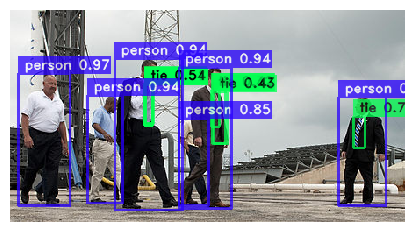

In [8]:
url = "/content/Elon_Musk_gives_tour_for_President_Barack_Obama.jpg"
yolo_nas_s.predict(url,conf=0.25).show()

In [9]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## FINE TUNING CUSTOM DATASET

In [10]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer =Trainer(experiment_name="my_first_yolonas_run",ckpt_root_dir=CHECKPOINT_DIR)

In [11]:
from roboflow import Roboflow
rf = Roboflow(api_key="flWSHuYrYHWU6vO27YUR")
project = rf.workspace("atathamuscoinsdataset").project("u.s.-coins-dataset-a.tatham")
version = project.version(9)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to U.S.-Coins-Dataset---A.Tatham-9 in yolov5pytorch::   0%|          | 0/4170 [00:00<?, ?it/s]

Extracting Dataset Version Zip to U.S.-Coins-Dataset---A.Tatham-9 in yolov5pytorch::  45%|████▍     | 1866/4170 [00:00<00:00, 4347.73it/s]

In [12]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import  coco_detection_yolo_format_train , coco_detection_yolo_format_val

In [ ]:
dataset_params = {
    'data_dir':'/content/U.S.-Coins-Dataset---A.Tatham-5',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Dime', 'Nickel', 'Penny', 'Quarter']
}

In [16]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 34/34 [00:00<00:00, 3736.18it/s]


In [17]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [18]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [19]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees']= 10.42

In [20]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.42, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

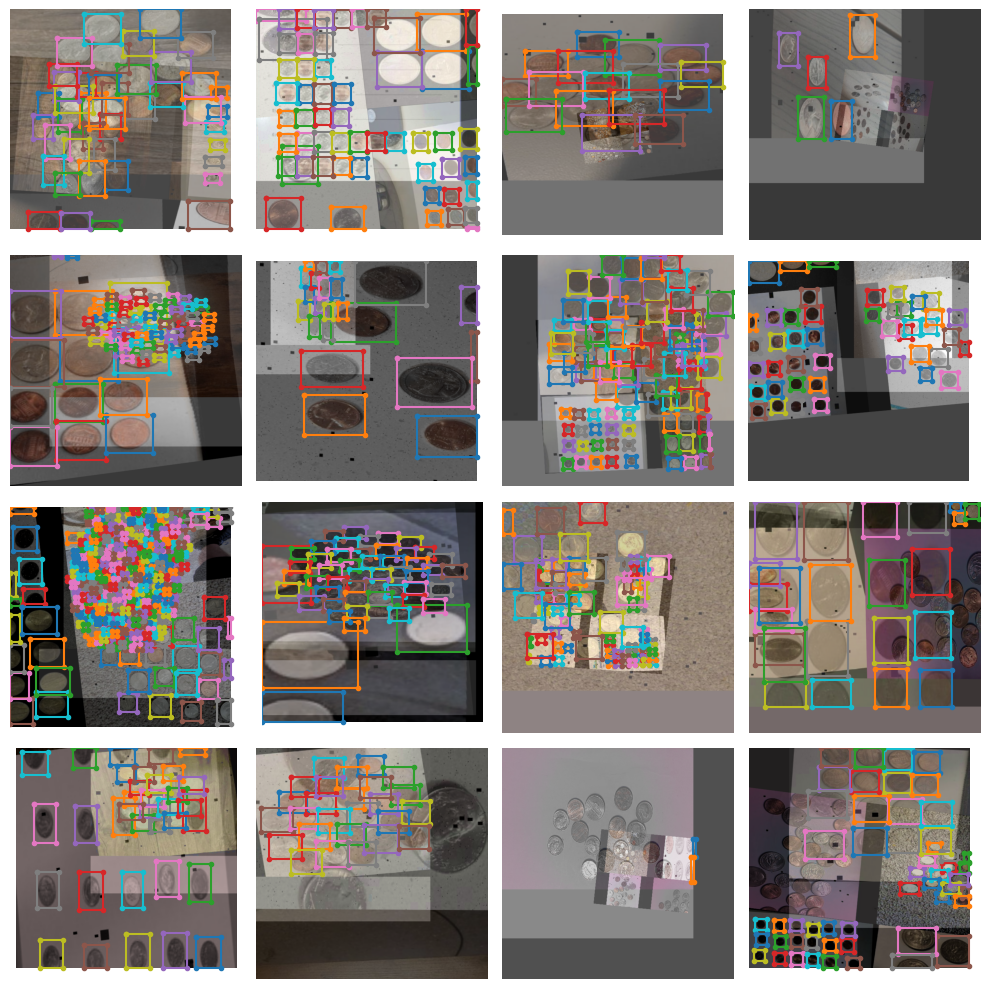

In [21]:
train_data.dataset.plot()

In [22]:
from super_gradients.training import models
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights='coco')



[2024-03-23 10:41:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-23 10:41:13] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [23]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [24]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_Mar23_10_41_19.txt


[2024-03-23 10:41:20] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-03-23 10:41:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1710       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         106        (len(train_loader))
    - Gradient updates per epoch:   106        (len(train_loader) / batch_accumulate)

[2024-03-23 10:42:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2024-03-23 10:42:30] INFO - sg_trainer.py - Best checkpoint overriden: val

In [26]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

In [27]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

{'PPYoloELoss/loss_cls': 0.6825248,
 'PPYoloELoss/loss_iou': 0.12151343,
 'PPYoloELoss/loss_dfl': 0.6720991,
 'PPYoloELoss/loss': 1.322358,
 'Precision@0.50': 0.1536949872970581,
 'Recall@0.50': 0.9918565154075623,
 'mAP@0.50': 0.9009138345718384,
 'F1@0.50': 0.2607981860637665}

[2024-03-23 10:59:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


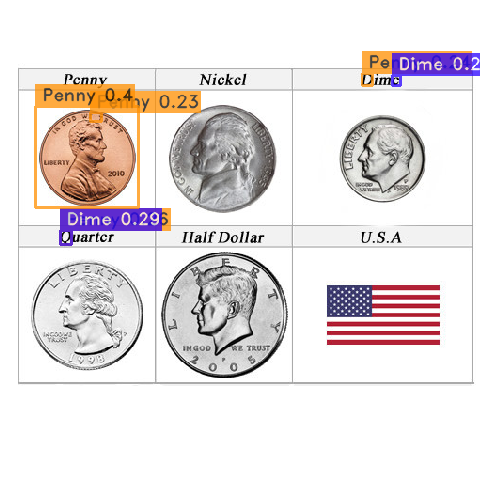

In [35]:
img_url = 'https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'
best_model.predict(img_url,conf=0.20).show()